# Advanced Programming Assignment 3: Mandelbrot zoom

Import libraries:

In [0]:
import numpy as np
import cv2 # open computer vision library, for video and image processing
import matplotlib.pyplot as plt

# 1. Python: `mandelbrot`
Define function `mandelbrot` with **Python**.

The numbers in the Mandelbrot set are all complex numbers $c$, such that the series $z_0=(0, 0)$ and $z_{t+1} = z_t^2 + c$ is bounded (i.e. it does not go to infinity). $c$ is a complex constant depending on the position in the image being processed. Set the pixel colour in relation to the number of iterations in the series before it diverges, defined as $|z_t| > 2$.

In [0]:
def mandelbrot(centre, view_side, n_max_iter = 500, view_side_pixels = 500):
  # The output is a square image, view_side is the size of the side of this
  # image in the complex plane. The view_side_pixels is the number of pixels
  # this correspond to.
  step = view_side/view_side_pixels
  # Store the pixels as a list of lists
  image = list()
  for i in range(view_side_pixels):
    image.append([])
    for j in range(view_side_pixels):
      # Find c for this pixel
      c = centre + view_side*complex(-.5, .5) + complex(j*step, -i*step)
      # Initial z
      z = complex(0, 0)
      # Iterate to generate the series
      n = 0
      # Loop until a maximum number of allowed iterations or until the 
      # series diverges.
      while n < n_max_iter and abs(z) < 2: 
        # The update
        z = z*z + c
        # Increase the iteration counter
        n += 1
      # If the series did diverge, store the number of iterations it took (our
      # colouring will be proportional to this). If not, store a zero.
      if n == n_max_iter:
        image[i].append(0)
      else:
        image[i].append(n)
  # Transform the list of lists into a numpy matrix
  return np.asarray(image)

# 2. Cython: `mandelbrot_cy`
Implement `mandelbrot_cy` with **Cython**.

load the cython extension:

In [0]:
%load_ext cython

In [5]:
%%cython -a
import numpy as np
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def mandelbrot_cy(complex centre, float view_side, int n_max_iter = 255, int view_side_pixels = 500):
  step = view_side/view_side_pixels
  cdef float step_memview = step

  cdef int i, j, n
  cdef double complex c
  cdef double complex z 
  cdef float cons_x = centre.real - view_side*.5
  cdef float cons_y = centre.imag + view_side*.5
  #cdef complex cons = centre + view_side*complex(-.5, .5)

  ret = np.zeros((view_side_pixels, view_side_pixels))
  cdef double[:, :] ret_memview = ret

  for i in range(view_side_pixels):
    for j in range(view_side_pixels):
        c = cons_x + j * step_memview + (cons_y - i * step_memview)*1j
        z = 0 + 0*1j
        n = 0
        #for n in range(n_max_iter):
         #   z = z*z + c
          #  if z.real**2 + z.imag**2 > 4:
           #     ret_memview[i, j] = n  
        while n < n_max_iter and z.real**2 + z.imag**2 <= 4: 
            z = z*z + c
            n += 1
        if n == n_max_iter:
            ret_memview[i, j] = 0
        else:
            ret_memview[i, j] = n    
  return ret

# 3. Compare Execution Times

In [0]:
import timeit

In [7]:
%timeit mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)
%timeit mandelbrot_cy(complex(-.74303, .126433), .01611, view_side_pixels = 200)

1 loop, best of 3: 1.76 s per loop
10 loops, best of 3: 28.5 ms per loop


# 4. Generate Image and Video
## 4.1. Image
View the generated image. 

A colourmap is applied to the raw counts of iterations before diverging. Note that opencv use BGR instead of RGB colour ordering.

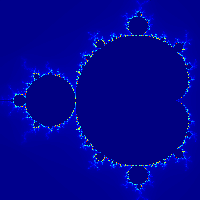

In [8]:
# Make the image
image = mandelbrot_cy(complex(-.5, 0), 2, view_side_pixels = 200)
# image = mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)

# Apply colourmap
img = np.asarray(255*image/np.max(image), dtype=np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

# Optional resize (makes it look better at higher resolutions)
# img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

# Write the image and view it
cv2.imwrite('fractal.png', img)
from IPython.display import Image
Image('fractal.png')

## 4.2. Video
Generate a 500-frame video at a 1000x1000 pixel resolution. However, since the video is too large, we only show every 25 frame:

In [0]:
def framemaker(zoom):
  # Create the image for the given parameters
  image = mandelbrot_cy(complex(-0.743643887037158704752191506114774, 
                                 0.131825904205311970493132056385139), view_side=zoom, n_max_iter=255, view_side_pixels=1000)
  # Apply colourmap
  img = np.asarray(255*image/np.max(image), dtype=np.uint8)
  img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
  # Optional resize (makes it look better at higher resolutions)
  img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)
  return img


In [0]:
from multiprocessing import Pool
import os

def parallizer():
  zoom = np.exp(np.linspace(np.log(1), np.log(.00001), 500))
  with Pool(processes=os.cpu_count()) as pool:
    frames = pool.map(framemaker, zoom)
  return frames

In [0]:
frames = parallizer()

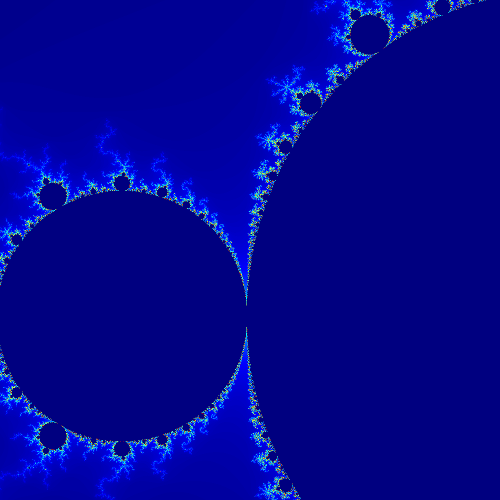

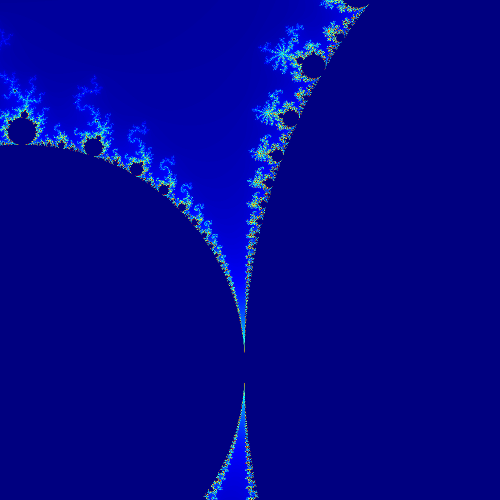

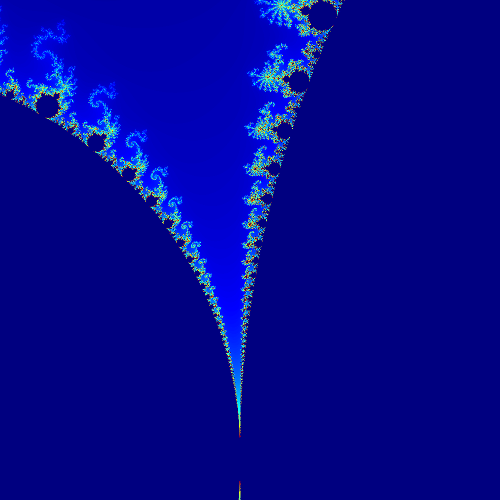

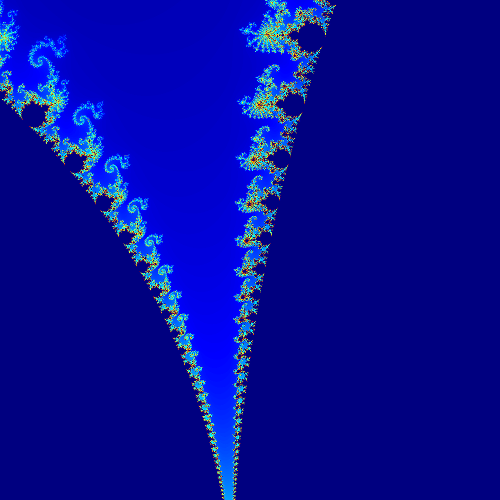

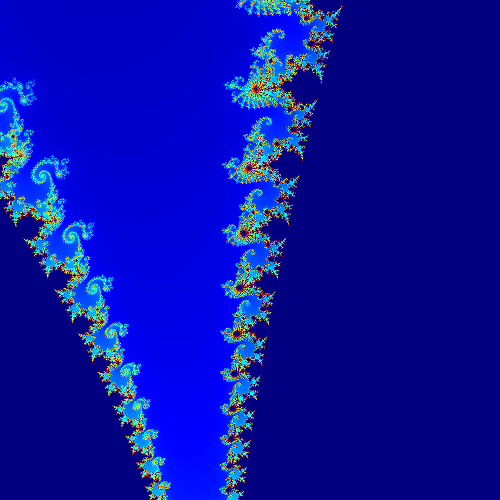

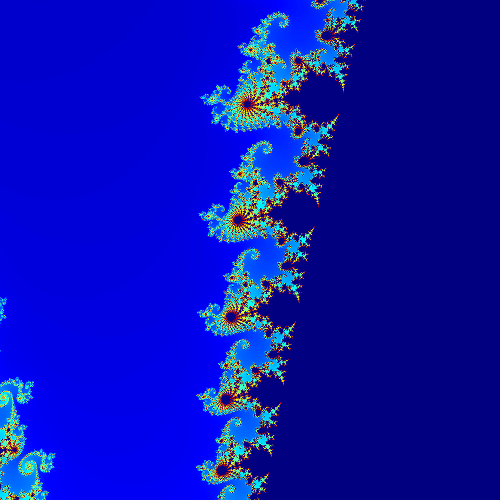

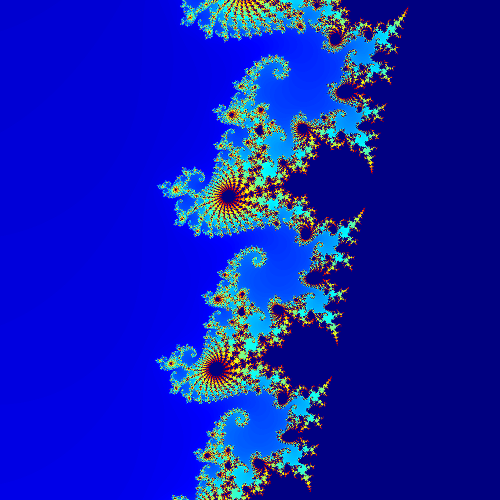

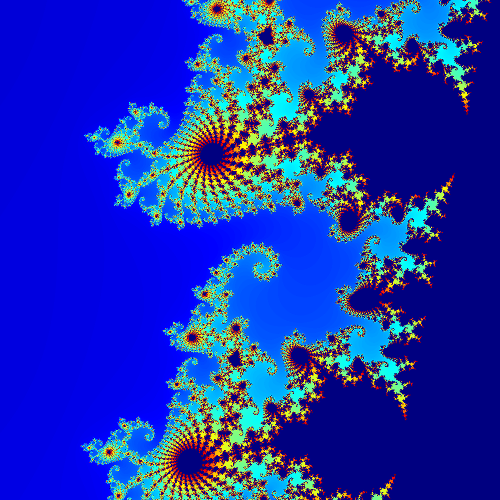

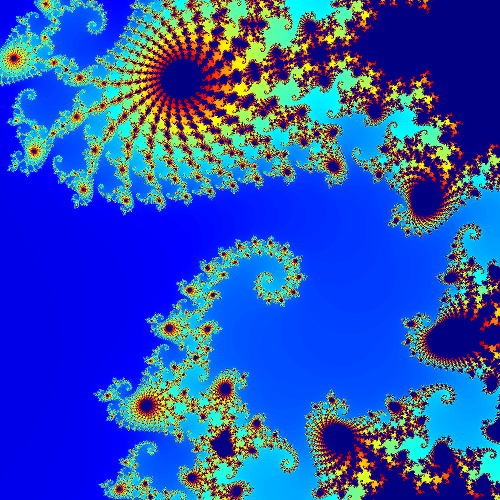

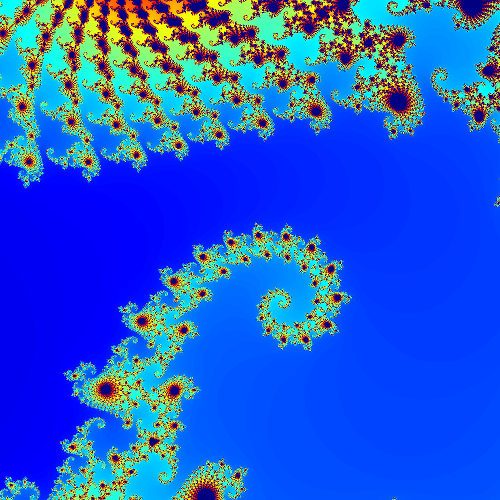

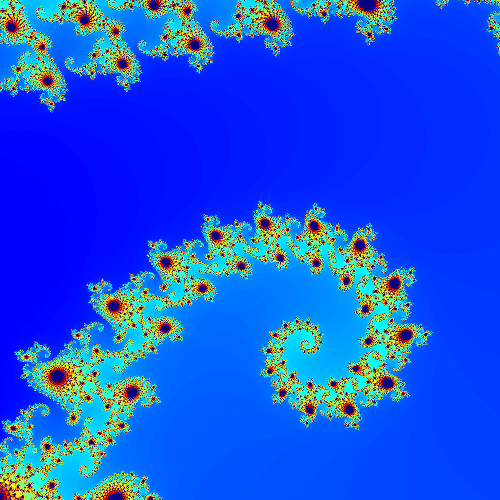

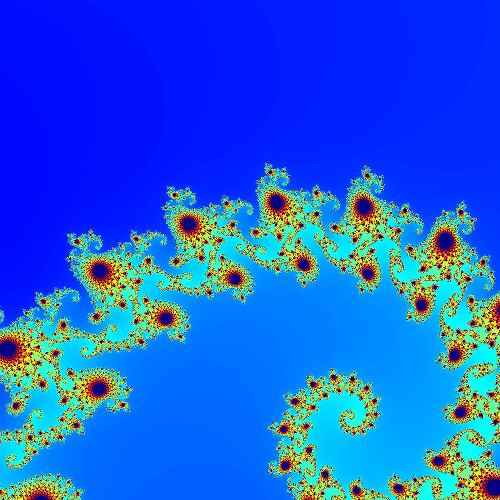

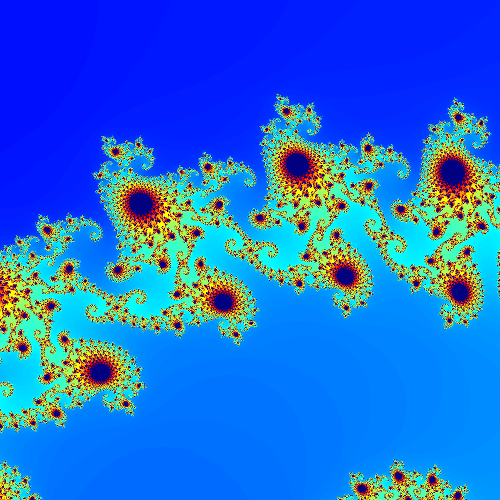

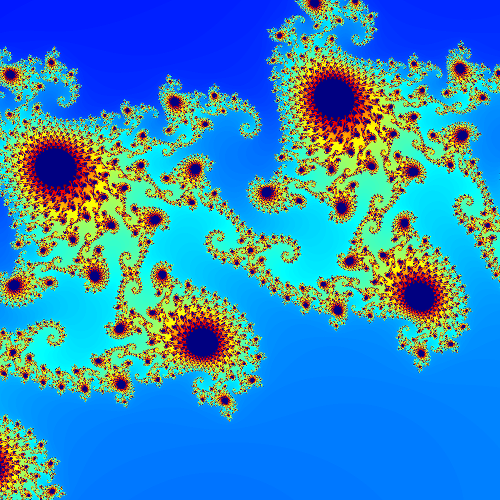

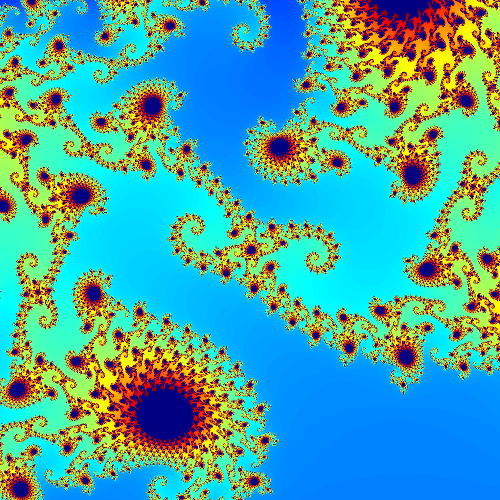

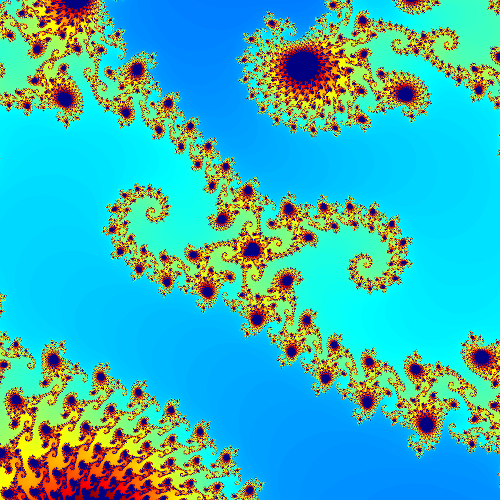

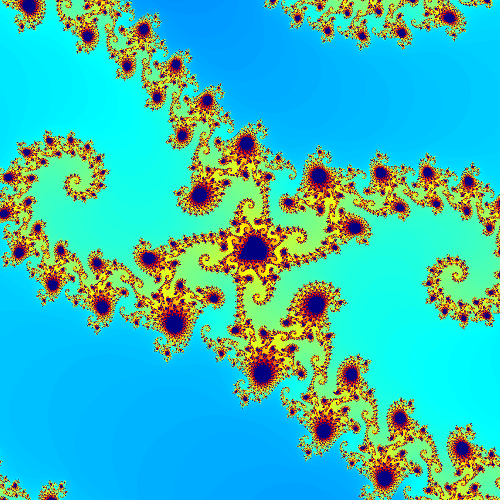

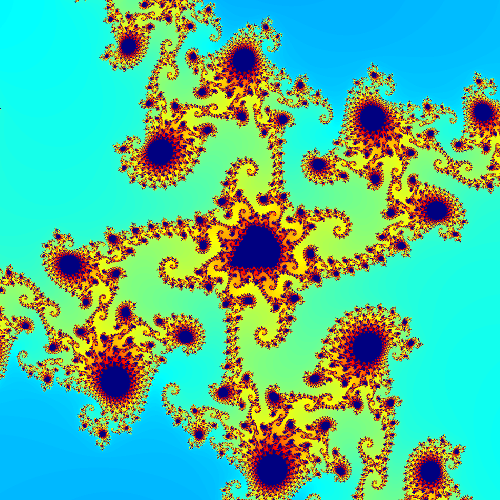

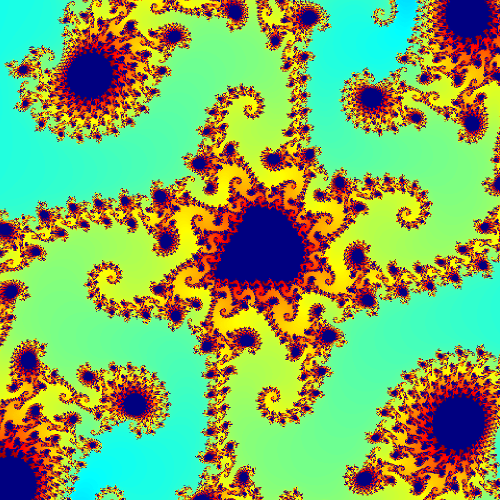

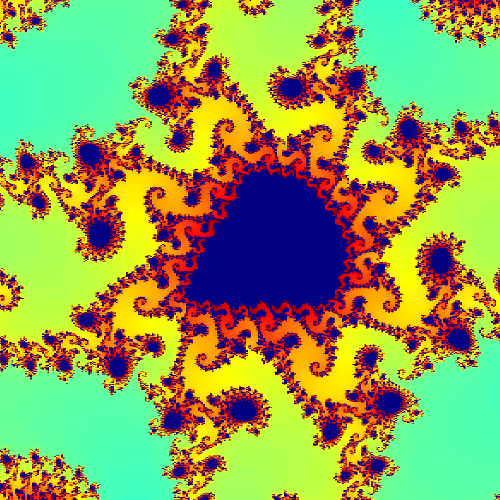

In [12]:
# Show every 25 rendered frame
from IPython.display import Image, display
Image('fractal.png')
for i in range(0,500,25):
  cv2.imwrite('fractal.png', frames[i])
  display(Image('fractal.png'))

### Comments
1. In the function `mandelbrot_cy`, when updating the matrix `ret` (of shape `(view_side_pixels, view_side_pixels)`), because there are two for loops, one nested within another, which makes it difficult to implement `map` to update the matrix in parallel. In other words, because the update process of the matrix needs to remember where it was in the previous step (i.e. position denoted by `(i ,j)`), therefore it cannot be run in parallel.

2. We tried to use `prange` as an alternative to `map` to let the outermose for-loop be run in parallel. However, this slowed down our function by maybe a quarter. This is in part because we needed to use a for-loop as the functions innermost loop (see the commented out code in mandelbrot_cy) which was slower than our finally used while-loop.

3. After speeding up, our implementation with Cython is around **60 times** than the original implementation using Python.